In [ ]:
# --- 2. Modell erstellen (Anzahl der Schichten und Neuronen) ---

def build_oscillator_model(num_hidden_layers=1,
                           neurons_per_layer=32,
                           activation_function='relu',
                           learning_rate=0.001):
    """
    Erstellt ein Keras-Modell für die Vorhersage eines gedämpften Oszillators.

    Args:
        num_hidden_layers (int): Anzahl der versteckten Schichten.
        neurons_per_layer (int): Anzahl der Neuronen in jeder versteckten Schicht.
        activation_function (str): Name der Aktivierungsfunktion für die versteckten Schichten.
        learning_rate (float): Die Lernrate für den Adam-Optimierer.

    Returns:
        keras.Model: Das kompilierte Keras-Modell.
    """
    model = keras.Sequential()

    # Eingabeschicht (implizit, durch die erste Dense-Schicht definiert)
    # Input-Shape ist (1,), da wir nur die Zeit als Eingabe haben
    model.add(layers.Dense(neurons_per_layer, input_shape=(1,), activation=activation_function))

    # Versteckte Schichten
    for _ in range(num_hidden_layers -1): # Beginnen bei 1, da die erste Schicht bereits hinzugefügt wurde
        model.add(layers.Dense(neurons_per_layer, activation=activation_function))

    # Ausgabeschicht
    # Da wir eine einzelne kontinuierliche Position vorhersagen, ist die Ausgabe ein einzelnes Neuron
    # und keine Aktivierungsfunktion (oder 'linear'), da wir keine Begrenzung der Ausgabe wünschen.
    model.add(layers.Dense(1, activation='linear')) # 'linear' ist die Standardaktivierung und kann weggelassen werden

    # --- 3. Optimierer konfigurieren ---
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # --- 4. Modell kompilieren ---
    # Metrik: Mean Absolute Error (MAE) ist gut, um die durchschnittliche absolute Abweichung zu sehen.
    # Mean Squared Error (MSE) ist ebenfalls üblich und sensitiver auf größere Fehler.
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# --- Konfiguration der Modellparameter (für Einfachheit und Präzision) ---
# Für "einfachst" und "höchste Präzision" müssen wir ein wenig experimentieren.
# Beginnen wir mit einem sehr einfachen Setup und passen es bei Bedarf an.

# Parameter für die Modellarchitektur
NUM_HIDDEN_LAYERS = 2     # Eine oder zwei versteckte Schichten sind oft ein guter Startpunkt.
                           # Für "einfachst" könnten wir sogar 1 versuchen.
NEURONS_PER_LAYER = 32     # Eine kleinere Anzahl von Neuronen (z.B. 16, 32, 64)
ACTIVATION_FUNCTION = 'relu' # ReLU ist eine gute Standardwahl. Auch 'tanh' könnte funktionieren.
LEARNING_RATE = 0.001      # Eine typische Lernrate für Adam.

# Erstelle das Modell
model = build_oscillator_model(num_hidden_layers=NUM_HIDDEN_LAYERS,
                               neurons_per_layer=NEURONS_PER_LAYER,
                               activation_function=ACTIVATION_FUNCTION,
                               learning_rate=LEARNING_RATE)

# Zeige eine Zusammenfassung des Modells (Parameteranzahl ist hier sichtbar)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Daten vorbereiten ---
def generate_damped_oscillator_data(num_samples=1000,
                                   amplitude=1.0,
                                   decay_constant=0.5,
                                   frequency=2.0,
                                   phase=0.0,
                                   noise_amplitude=0.00):
    """
    Generiert synthetische Daten für einen gedämpften harmonischen Oszillator.

    Args:
        num_samples (int): Anzahl der zu generierenden Datenpunkte.
        amplitude (float): Anfangsamplitude des Oszillators.
        decay_constant (float): Die Abklingkonstante (Gamma).
        frequency (float): Die Winkelfrequenz (Omega).
        phase (float): Die Phasenverschiebung.
        noise_amplitude (float): Amplitude des hinzugefügten Rauschens.

    Returns:
        tuple: Ein Tupel von (time_steps, positions)
    """
    time_steps = np.linspace(0, 10, num_samples) # Zeit von 0 bis 10
    true_positions = amplitude * np.exp(-decay_constant * time_steps) * \
                     np.cos(frequency * time_steps + phase)
    # Rauschen hinzufügen, um das Modell robuster zu machen
    noise = noise_amplitude * np.random.randn(num_samples)
    positions = true_positions + noise
    return time_steps, positions

# Generieren der Daten
time_data, position_data = generate_damped_oscillator_data()

# Daten für Keras vorbereiten (Input muss 2D sein, Output kann 1D sein)
# reshape(-1, 1) stellt sicher, dass es eine Spalte und beliebig viele Zeilen hat
X = time_data.reshape(-1, 1)
y = position_data

# Daten aufteilen in Trainings- und Testsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape von X_train: {X_train.shape}")
print(f"Shape von y_train: {y_train.shape}")
print(f"Shape von X_test: {X_test.shape}")
print(f"Shape von y_test: {y_test.shape}")

Shape von X_train: (800, 1)
Shape von y_train: (800,)
Shape von X_test: (200, 1)
Shape von y_test: (200,)


In [14]:
# --- 5. Modell trainieren ---
# Das Training kann eine Weile dauern, abhängig von der Datenmenge und der Modellkomplexität.
# 'epochs' ist die Anzahl der Trainingsdurchläufe über den gesamten Datensatz.
# 'batch_size' ist die Anzahl der Samples, die pro Aktualisierung der Modellgewichte verwendet werden.
# 'validation_split' reserviert einen Teil der Trainingsdaten für die Validierung während des Trainings.
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # verbose=1 zeigt den Trainingsfortschritt an



Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
E


Verlust (MSE) auf dem Testset: 0.0000
Mittlere absolute Abweichung (MAE) auf dem Testset: 0.0026
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


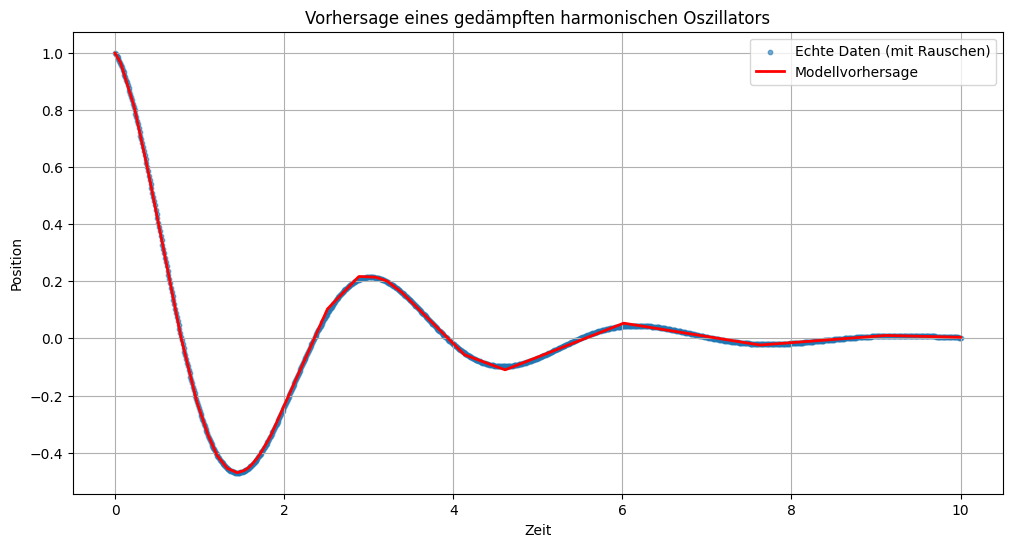

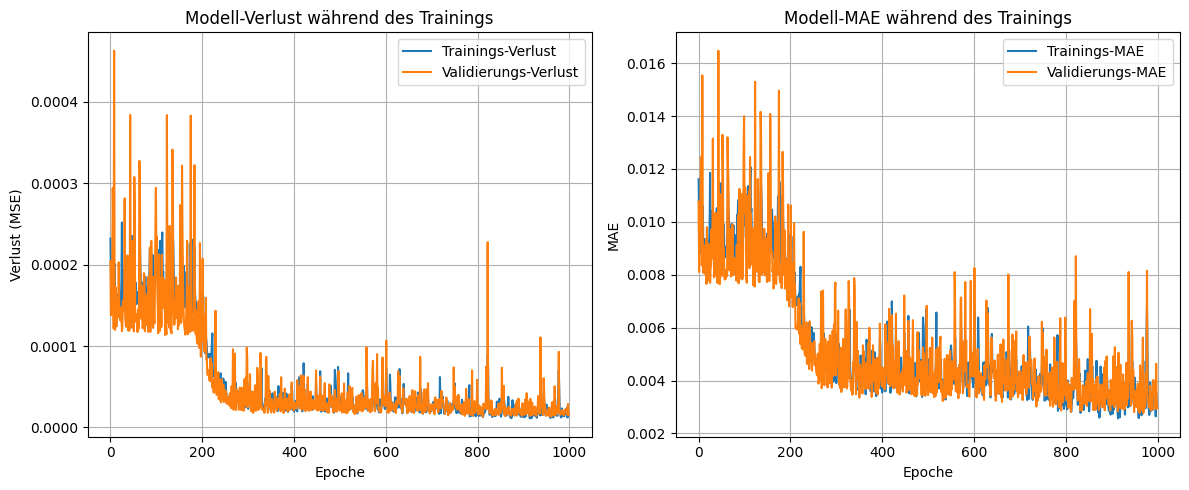

In [15]:
# --- 6. Modell evaluieren ---
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nVerlust (MSE) auf dem Testset: {loss:.4f}")
print(f"Mittlere absolute Abweichung (MAE) auf dem Testset: {mae:.4f}")

# --- Vorhersagen machen und visualisieren ---
y_pred = model.predict(X)

plt.figure(figsize=(12, 6))
plt.scatter(X, y, label='Echte Daten (mit Rauschen)', alpha=0.6, s=10)
plt.plot(X, y_pred, color='red', label='Modellvorhersage', linewidth=2)
plt.title('Vorhersage eines gedämpften harmonischen Oszillators')
plt.xlabel('Zeit')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Trainingsverlauf plotten
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Trainings-Verlust')
plt.plot(history.history['val_loss'], label='Validierungs-Verlust')
plt.title('Modell-Verlust während des Trainings')
plt.xlabel('Epoche')
plt.ylabel('Verlust (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Trainings-MAE')
plt.plot(history.history['val_mae'], label='Validierungs-MAE')
plt.title('Modell-MAE während des Trainings')
plt.xlabel('Epoche')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Test 2

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2109 - mean_absolute_error: 0.3768 - val_loss: 0.0505 - val_mean_absolute_error: 0.1884
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0685 - mean_absolute_error: 0.1801 - val_loss: 0.0339 - val_mean_absolute_error: 0.1228
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0546 - mean_absolute_error: 0.1404 - val_loss: 0.0332 - val_mean_absolute_error: 0.1111
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0474 - mean_absolute_error: 0.1239 - val_loss: 0.0322 - val_mean_absolute_error: 0.1130
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0482 - mean_absolute_error: 0.1311 - val_loss: 0.0317 - val_mean_absolute_error: 0.1135
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0435 - mean_absolute_error: 0.1288 - val_loss: 0.0303 - val_mean_absolute_error: 0.1090
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0414 - mean_absolute_error: 0.1238 - 

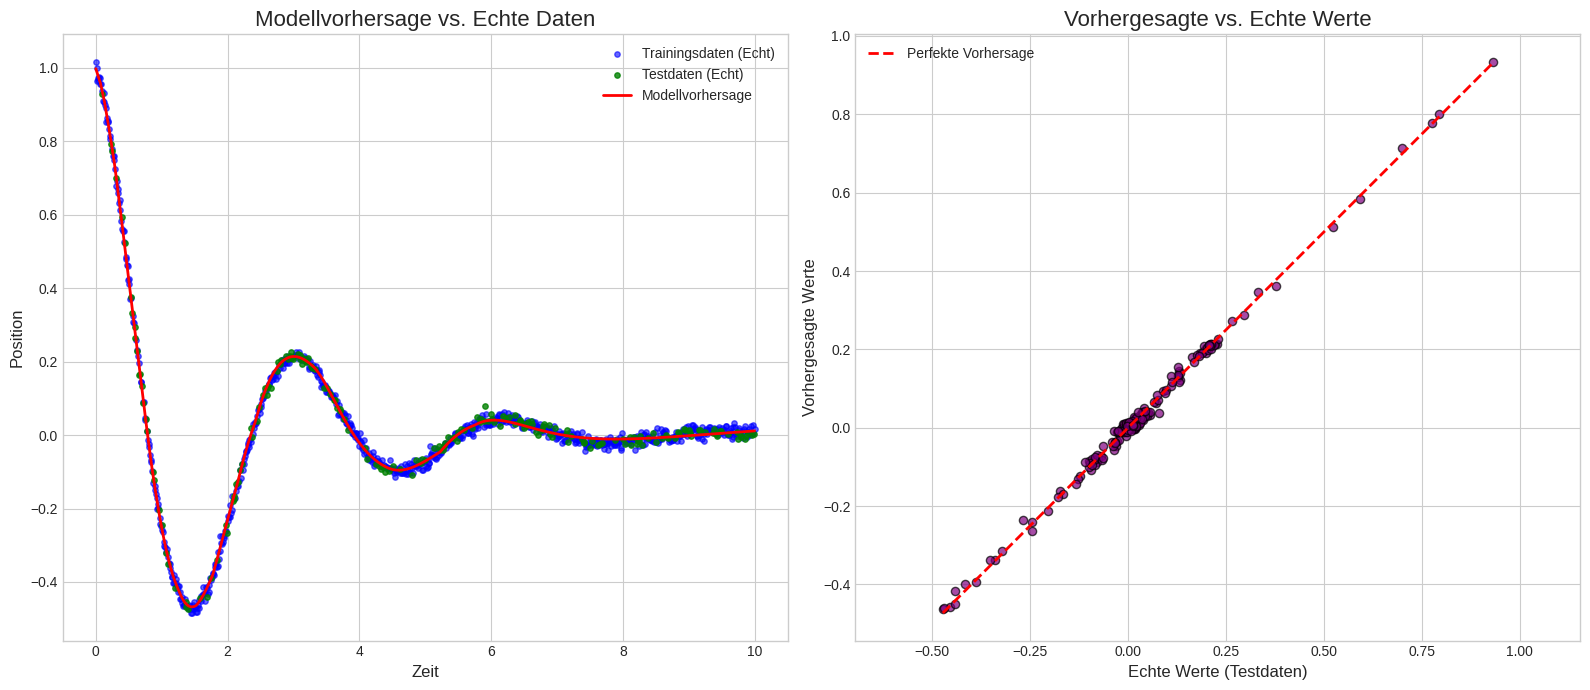

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- 1. Daten vorbereiten ---
def generate_damped_oscillator_data(num_samples=1000, noise_amplitude=0.01):
    """Generiert synthetische Daten für einen gedämpften Oszillator."""
    time_steps = np.linspace(0, 10, num_samples)
    positions = 1.0 * np.exp(-0.5 * time_steps) * np.cos(2.0 * time_steps) + \
                noise_amplitude * np.random.randn(num_samples)
    return time_steps, positions

# Daten generieren und aufteilen
time_data, position_data = generate_damped_oscillator_data()
X = time_data.reshape(-1, 1)
y = position_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Modell erstellen und kompilieren ---
def build_simple_model(input_shape=(1,)):
    """Erstellt das spezifizierte neuronale Netz."""
    model = tf.keras.Sequential([
        # 1. Versteckte Schicht: 32 Neuronen, ReLU Aktivierung
        layers.Dense(32, activation='relu', input_shape=input_shape),
        # 2. Versteckte Schicht: 32 Neuronen, Tanh Aktivierung
        layers.Dense(32, activation='tanh'),
        # Ausgabeschicht: 1 Neuron für die Vorhersage der Position
        layers.Dense(1)
    ])

    # Modell kompilieren mit dem Adam-Optimierer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error', # Übliche Verlustfunktion für Regression
                  metrics=['mean_absolute_error'])
    return model

# Modell instanziieren und Zusammenfassung anzeigen
model = build_simple_model()
model.summary()

# --- 3. Modell trainieren ---
# Callback für Early Stopping: Stoppt das Training, wenn sich der Validierungsverlust nicht mehr verbessert.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=50, # Anzahl der Epochen ohne Verbesserung, bevor gestoppt wird
    restore_best_weights=True # Stellt die besten Gewichte am Ende wieder her
)

# Training starten
history = model.fit(
    X_train, y_train,
    epochs=1000, # Maximale Anzahl an Epochen
    validation_data=(X_test, y_test), # Wir verwenden das Test-Set zur Validierung
    batch_size=32,
    callbacks=[early_stopping_callback], # Callback übergeben
    verbose=1 # Weniger detaillierte Ausgabe während des Trainings
)

# --- 4. Modell evaluieren und visualisieren ---
print("\nModell-Evaluierung auf dem Testset:")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"  - Mittlerer quadratischer Fehler (MSE): {loss:.4f}")
print(f"  - Mittlere absolute Abweichung (MAE): {mae:.4f}")

# Vorhersagen für beide Datensätze machen
y_pred_full = model.predict(X)
y_pred_test = model.predict(X_test)


# --- Visualisierung ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Vorhersage über die gesamten Daten
ax1.scatter(X_train, y_train, label='Trainingsdaten (Echt)', alpha=0.6, s=15, color='blue')
ax1.scatter(X_test, y_test, label='Testdaten (Echt)', alpha=0.8, s=15, color='green')
ax1.plot(time_data, y_pred_full, color='red', linewidth=2, label='Modellvorhersage')
ax1.set_title('Modellvorhersage vs. Echte Daten', fontsize=16)
ax1.set_xlabel('Zeit', fontsize=12)
ax1.set_ylabel('Position', fontsize=12)
ax1.legend(fontsize=10)

# Plot 2: Vorhergesagte vs. Echte Werte (Predicted vs. Actual)
ax2.scatter(y_test, y_pred_test, alpha=0.7, color='purple', edgecolors='k', s=35)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfekte Vorhersage')
ax2.set_title('Vorhergesagte vs. Echte Werte', fontsize=16)
ax2.set_xlabel('Echte Werte (Testdaten)', fontsize=12)
ax2.set_ylabel('Vorhergesagte Werte', fontsize=12)
ax2.legend(fontsize=10)
ax2.axis('equal') # Sorgt für ein quadratisches Plotverhältnis

plt.tight_layout()
plt.show()

- Layer: 1 (32 ReLU, 32 Tanh, 1 out)
- Parameters: 1153
- Epochs: 1000
- MSE: 0.000
- MAE: 0.033

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1025 - mean_absolute_error: 0.2523 - val_loss: 0.0368 - val_mean_absolute_error: 0.1263
Epoch 2/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0630 - mean_absolute_error: 0.1489 - val_loss: 0.0346 - val_mean_absolute_error: 0.1102
Epoch 3/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0630 - mean_absolute_error: 0.1433 - val_loss: 0.0338 - val_mean_absolute_error: 0.1153
Epoch 4/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0536 - mean_absolute_error: 0.1401 - val_loss: 0.0330 - val_mean_absolute_error: 0.1129
Epoch 5/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0556 - mean_absolute_error: 0.1373 - val_loss: 0.0343 - val_mean_absolute_error: 0.1157
Epoch 6/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0460 - mean_absolute_error: 0.1332 - val_loss: 0.0322 - val_mean_absolute_error: 0.1163
Epoch 7/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0398 - mean_absolute_error: 0.1211 - 

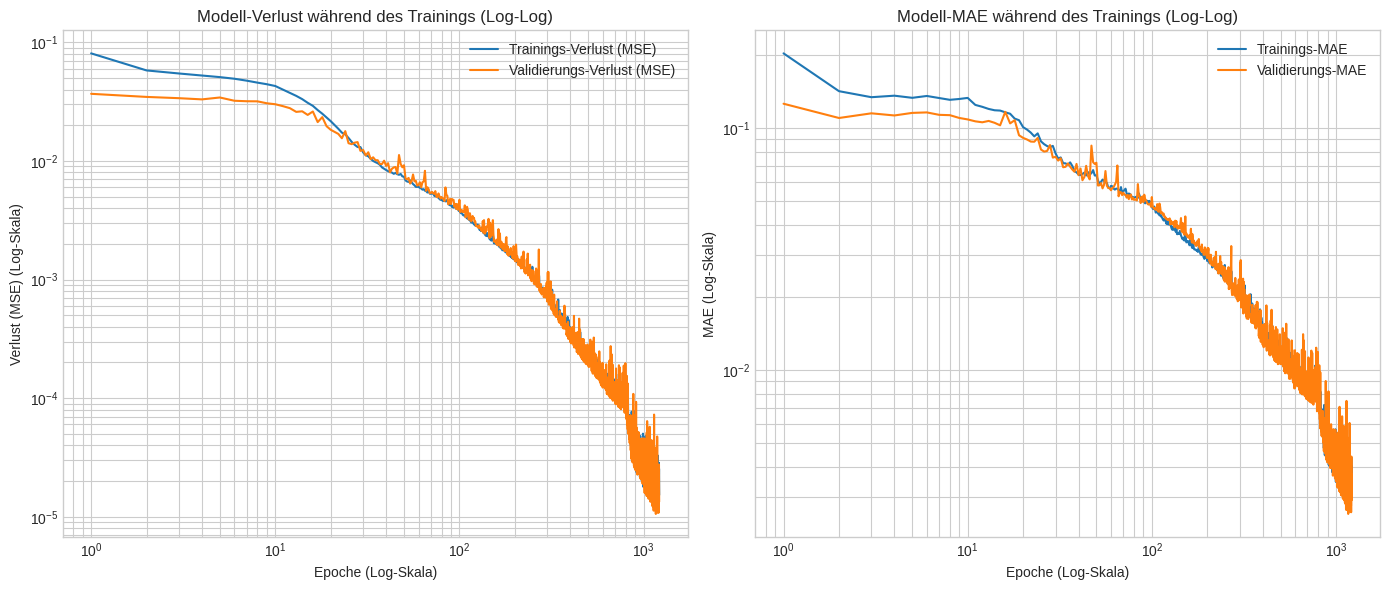

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


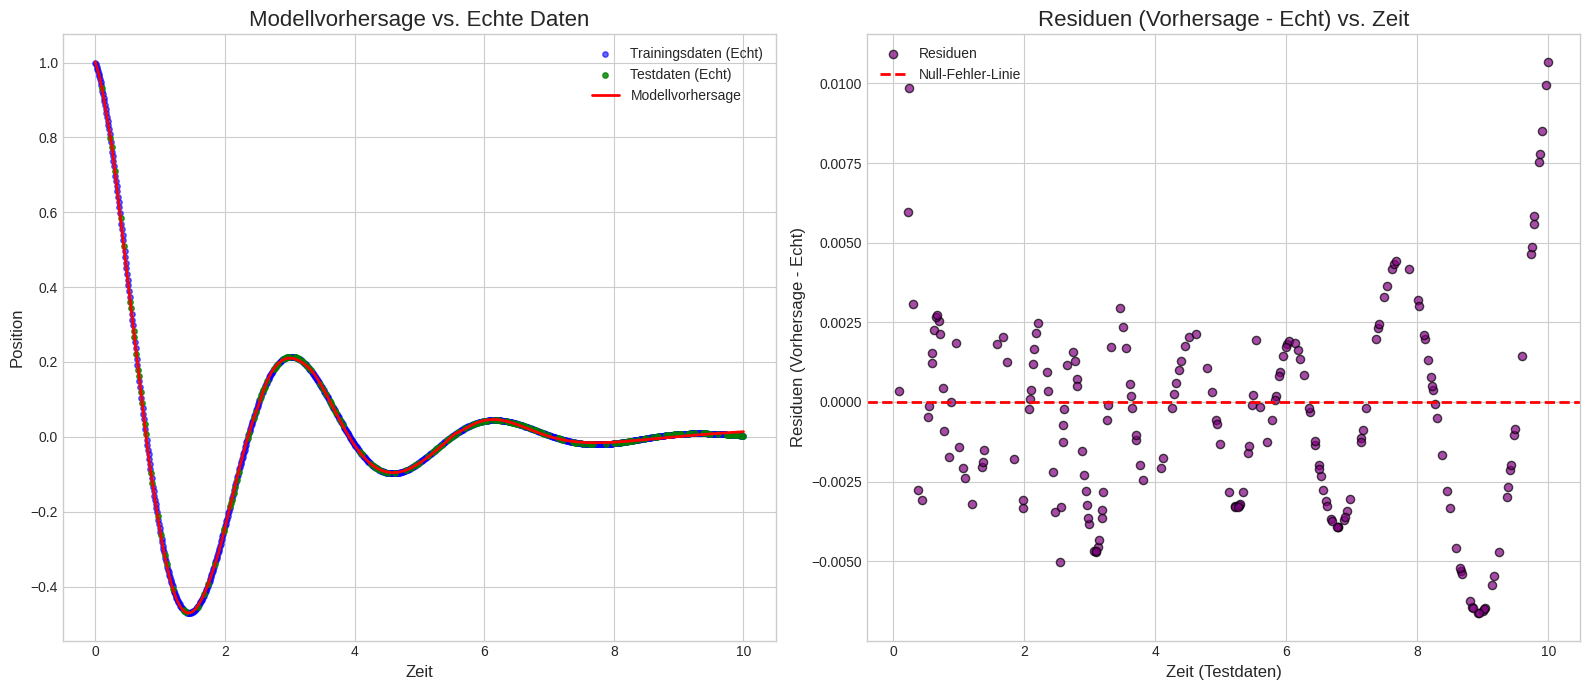

In [24]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- 1. Daten vorbereiten ---
def generate_damped_oscillator_data(num_samples=1000, noise_amplitude=0.00):
    """Generiert synthetische Daten für einen gedämpften Oszillator."""
    time_steps = np.linspace(0, 10, num_samples)
    positions = 1.0 * np.exp(-0.5 * time_steps) * np.cos(2.0 * time_steps) + \
                noise_amplitude * np.random.randn(num_samples)
    return time_steps, positions

# Daten generieren und aufteilen
time_data, position_data = generate_damped_oscillator_data()
X = time_data.reshape(-1, 1)
y = position_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Modell erstellen und kompilieren ---
def build_simple_model(input_shape=(1,)):
    """Erstellt das spezifizierte neuronale Netz."""
    model = tf.keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=input_shape),
        layers.Dense(32, activation='tanh'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

model = build_simple_model()
model.summary()

# --- 3. Modell trainieren ---
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=2000,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping_callback],
    verbose=1
)

# --- 4. Modell evaluieren ---
print("\nModell-Evaluierung auf dem Testset:")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"  - Mittlerer quadratischer Fehler (MSE): {loss:.4f}")
print(f"  - Mittlere absolute Abweichung (MAE): {mae:.4f}")

# --- 5. Trainingsverlauf visualisieren (Log-Log Plots) ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 6))

# Plot für den Trainings- und Validierungsverlust (MSE) im Log-Log-Maßstab
ax1 = plt.subplot(1, 2, 1)
# Erstelle Epochen-Array für die x-Achse (beginnend bei 1)
epochs_range = range(1, len(history.history['loss']) + 1)
ax1.loglog(epochs_range, history.history['loss'], label='Trainings-Verlust (MSE)')
ax1.loglog(epochs_range, history.history['val_loss'], label='Validierungs-Verlust (MSE)')
ax1.set_title('Modell-Verlust während des Trainings (Log-Log)')
ax1.set_xlabel('Epoche (Log-Skala)')
ax1.set_ylabel('Verlust (MSE) (Log-Skala)')
ax1.legend()
ax1.grid(True, which="both", ls="-") # Gitter für Log-Skala anpassen

# Plot für die Trainings- und Validierungs-MAE im Log-Log-Maßstab
ax2 = plt.subplot(1, 2, 2)
ax2.loglog(epochs_range, history.history['mean_absolute_error'], label='Trainings-MAE')
ax2.loglog(epochs_range, history.history['val_mean_absolute_error'], label='Validierungs-MAE')
ax2.set_title('Modell-MAE während des Trainings (Log-Log)')
ax2.set_xlabel('Epoche (Log-Skala)')
ax2.set_ylabel('MAE (Log-Skala)')
ax2.legend()
ax2.grid(True, which="both", ls="-") # Gitter für Log-Skala anpassen

plt.tight_layout()
plt.show()


# --- 6. Vorhersagen visualisieren (mit geändertem zweiten Plot) ---
# Vorhersagen für beide Datensätze machen
y_pred_full = model.predict(X)
y_pred_test = model.predict(X_test) # Wird (Anzahl_Samples, 1) zurückgeben

fig, (ax1_viz, ax2_viz) = plt.subplots(1, 2, figsize=(16, 7)) # Umbenannt, um Konflikte mit obigen ax1, ax2 zu vermeiden

# Plot 1: Vorhersage über die gesamten Daten (BLEIBT GLEICH)
ax1_viz.scatter(X_train, y_train, label='Trainingsdaten (Echt)', alpha=0.6, s=15, color='blue')
ax1_viz.scatter(X_test, y_test, label='Testdaten (Echt)', alpha=0.8, s=15, color='green')
ax1_viz.plot(time_data, y_pred_full, color='red', linewidth=2, label='Modellvorhersage')
ax1_viz.set_title('Modellvorhersage vs. Echte Daten', fontsize=16)
ax1_viz.set_xlabel('Zeit', fontsize=12)
ax1_viz.set_ylabel('Position', fontsize=12)
ax1_viz.legend(fontsize=10)
ax1_viz.grid(True)

# Plot 2: Residuen (y_vorhergesagt - y_echt) vs. Zeit (NEU)
# Stelle sicher, dass y_test und y_pred_test die gleiche Form für die Subtraktion haben
# y_test ist (n_samples,), y_pred_test ist (n_samples, 1), also y_pred_test.flatten() verwenden
residuals = y_pred_test.flatten() - y_test
time_test_flat = X_test.flatten() # X_test ist (n_samples, 1)

# Sortiere Residuen nach Zeit für eine saubere Linienzeichnung, falls gewünscht,
# oder verwende einen Scatterplot, der keine Sortierung benötigt.
# Für einen Scatterplot ist keine Sortierung notwendig.
ax2_viz.scatter(time_test_flat, residuals, alpha=0.7, color='purple', edgecolors='k', s=35, label='Residuen')
ax2_viz.axhline(0, color='red', linestyle='--', lw=2, label='Null-Fehler-Linie') # Linie bei y=0
ax2_viz.set_title('Residuen (Vorhersage - Echt) vs. Zeit', fontsize=16)
ax2_viz.set_xlabel('Zeit (Testdaten)', fontsize=12)
ax2_viz.set_ylabel('Residuen (Vorhersage - Echt)', fontsize=12)
ax2_viz.legend(fontsize=10)
ax2_viz.grid(True)

plt.tight_layout()
plt.show()

- Hidden Layers:2 (32 tanh, 32 ReLU)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1007 - mean_absolute_error: 0.2523 - val_loss: 0.0363 - val_mean_absolute_error: 0.1287
Epoch 2/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0552 - mean_absolute_error: 0.1527 - val_loss: 0.0322 - val_mean_absolute_error: 0.1148
Epoch 3/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0542 - mean_absolute_error: 0.1410 - val_loss: 0.0291 - val_mean_absolute_error: 0.1113
Epoch 4/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0407 - mean_absolute_error: 0.1294 - val_loss: 0.0266 - val_mean_absolute_error: 0.1075
Epoch 5/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0327 - mean_absolute_error: 0.1170 - val_loss: 0.0246 - val_mean_absolute_error: 0.1028
Epoch 6/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0308 - mean_absolute_error: 0.1148 - val_loss: 0.0222 - val_mean_absolute_error: 0.1081
Epoch 7/2000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 - mean_absolute_error: 0.1153 - 

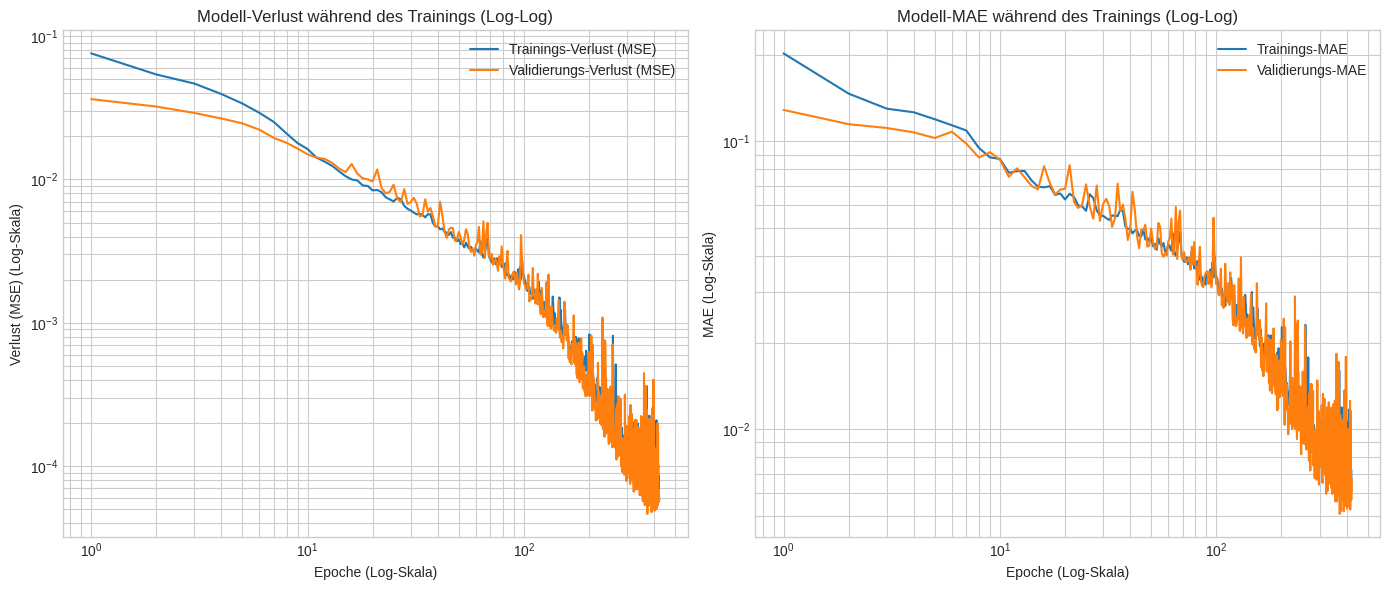

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


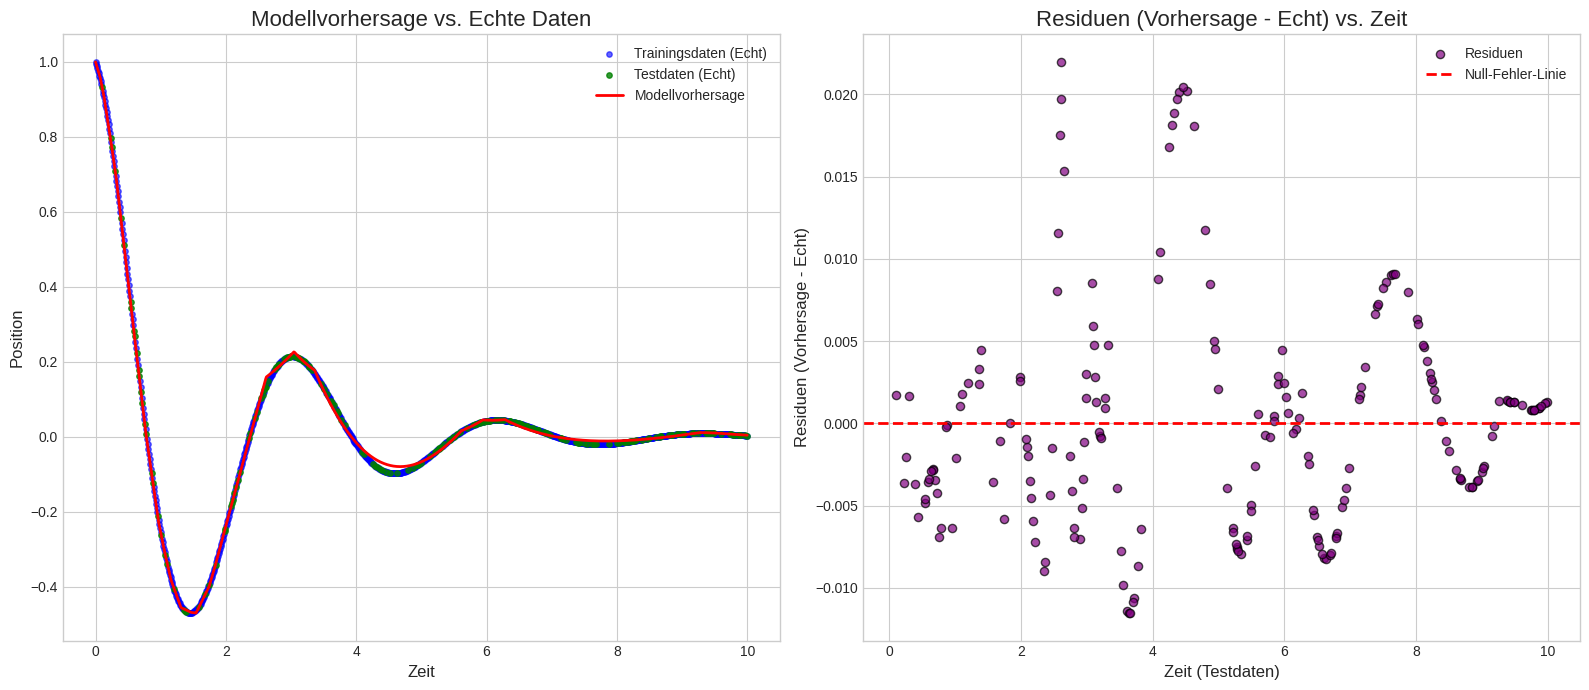

In [25]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- 1. Daten vorbereiten ---
def generate_damped_oscillator_data(num_samples=1000, noise_amplitude=0.00):
    """Generiert synthetische Daten für einen gedämpften Oszillator."""
    time_steps = np.linspace(0, 10, num_samples)
    positions = 1.0 * np.exp(-0.5 * time_steps) * np.cos(2.0 * time_steps) + \
                noise_amplitude * np.random.randn(num_samples)
    return time_steps, positions

# Daten generieren und aufteilen
time_data, position_data = generate_damped_oscillator_data()
X = time_data.reshape(-1, 1)
y = position_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Modell erstellen und kompilieren ---
def build_simple_model(input_shape=(1,)):
    """Erstellt das spezifizierte neuronale Netz."""
    model = tf.keras.Sequential([
        layers.Dense(32, activation='tanh', input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

model = build_simple_model()
model.summary()

# --- 3. Modell trainieren ---
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=2000,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping_callback],
    verbose=1
)

# --- 4. Modell evaluieren ---
print("\nModell-Evaluierung auf dem Testset:")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"  - Mittlerer quadratischer Fehler (MSE): {loss:.4f}")
print(f"  - Mittlere absolute Abweichung (MAE): {mae:.4f}")

# --- 5. Trainingsverlauf visualisieren (Log-Log Plots) ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 6))

# Plot für den Trainings- und Validierungsverlust (MSE) im Log-Log-Maßstab
ax1 = plt.subplot(1, 2, 1)
# Erstelle Epochen-Array für die x-Achse (beginnend bei 1)
epochs_range = range(1, len(history.history['loss']) + 1)
ax1.loglog(epochs_range, history.history['loss'], label='Trainings-Verlust (MSE)')
ax1.loglog(epochs_range, history.history['val_loss'], label='Validierungs-Verlust (MSE)')
ax1.set_title('Modell-Verlust während des Trainings (Log-Log)')
ax1.set_xlabel('Epoche (Log-Skala)')
ax1.set_ylabel('Verlust (MSE) (Log-Skala)')
ax1.legend()
ax1.grid(True, which="both", ls="-") # Gitter für Log-Skala anpassen

# Plot für die Trainings- und Validierungs-MAE im Log-Log-Maßstab
ax2 = plt.subplot(1, 2, 2)
ax2.loglog(epochs_range, history.history['mean_absolute_error'], label='Trainings-MAE')
ax2.loglog(epochs_range, history.history['val_mean_absolute_error'], label='Validierungs-MAE')
ax2.set_title('Modell-MAE während des Trainings (Log-Log)')
ax2.set_xlabel('Epoche (Log-Skala)')
ax2.set_ylabel('MAE (Log-Skala)')
ax2.legend()
ax2.grid(True, which="both", ls="-") # Gitter für Log-Skala anpassen

plt.tight_layout()
plt.show()


# --- 6. Vorhersagen visualisieren (mit geändertem zweiten Plot) ---
# Vorhersagen für beide Datensätze machen
y_pred_full = model.predict(X)
y_pred_test = model.predict(X_test) # Wird (Anzahl_Samples, 1) zurückgeben

fig, (ax1_viz, ax2_viz) = plt.subplots(1, 2, figsize=(16, 7)) # Umbenannt, um Konflikte mit obigen ax1, ax2 zu vermeiden

# Plot 1: Vorhersage über die gesamten Daten (BLEIBT GLEICH)
ax1_viz.scatter(X_train, y_train, label='Trainingsdaten (Echt)', alpha=0.6, s=15, color='blue')
ax1_viz.scatter(X_test, y_test, label='Testdaten (Echt)', alpha=0.8, s=15, color='green')
ax1_viz.plot(time_data, y_pred_full, color='red', linewidth=2, label='Modellvorhersage')
ax1_viz.set_title('Modellvorhersage vs. Echte Daten', fontsize=16)
ax1_viz.set_xlabel('Zeit', fontsize=12)
ax1_viz.set_ylabel('Position', fontsize=12)
ax1_viz.legend(fontsize=10)
ax1_viz.grid(True)

# Plot 2: Residuen (y_vorhergesagt - y_echt) vs. Zeit (NEU)
# Stelle sicher, dass y_test und y_pred_test die gleiche Form für die Subtraktion haben
# y_test ist (n_samples,), y_pred_test ist (n_samples, 1), also y_pred_test.flatten() verwenden
residuals = y_pred_test.flatten() - y_test
time_test_flat = X_test.flatten() # X_test ist (n_samples, 1)

# Sortiere Residuen nach Zeit für eine saubere Linienzeichnung, falls gewünscht,
# oder verwende einen Scatterplot, der keine Sortierung benötigt.
# Für einen Scatterplot ist keine Sortierung notwendig.
ax2_viz.scatter(time_test_flat, residuals, alpha=0.7, color='purple', edgecolors='k', s=35, label='Residuen')
ax2_viz.axhline(0, color='red', linestyle='--', lw=2, label='Null-Fehler-Linie') # Linie bei y=0
ax2_viz.set_title('Residuen (Vorhersage - Echt) vs. Zeit', fontsize=16)
ax2_viz.set_xlabel('Zeit (Testdaten)', fontsize=12)
ax2_viz.set_ylabel('Residuen (Vorhersage - Echt)', fontsize=12)
ax2_viz.legend(fontsize=10)
ax2_viz.grid(True)

plt.tight_layout()
plt.show()

- Layers: 2 (32 ReLU, 16 tanh, 1 out)
- Parameters:
- Epochs:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0781 - mean_absolute_error: 0.1798 - val_loss: 0.0352 - val_mean_absolute_error: 0.1148
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0530 - mean_absolute_error: 0.1356 - val_loss: 0.0360 - val_mean_absolute_error: 0.1264
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0467 - mean_absolute_error: 0.1343 - val_loss: 0.0323 - val_mean_absolute_error: 0.1097
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0482 - mean_absolute_error: 0.1360 - val_loss: 0.0314 - val_mean_absolute_error: 0.1110
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0534 - mean_absolute_error: 0.1427 - val_loss: 0.0319 - val_mean_absolute_error: 0.1111
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0427 - mean_absolute_error: 0.1256 - val_loss: 0.0308 - val_mean_absolute_error: 0.1124
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0389 - mean_absolute_error: 0.1284 - 

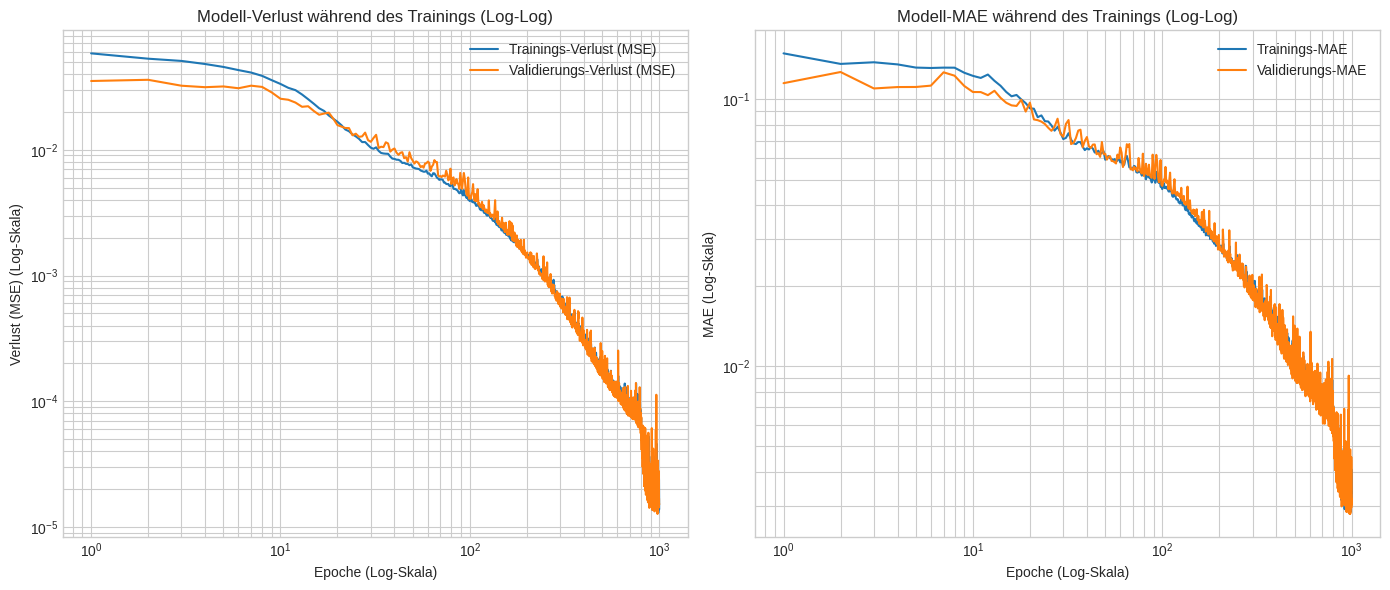

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


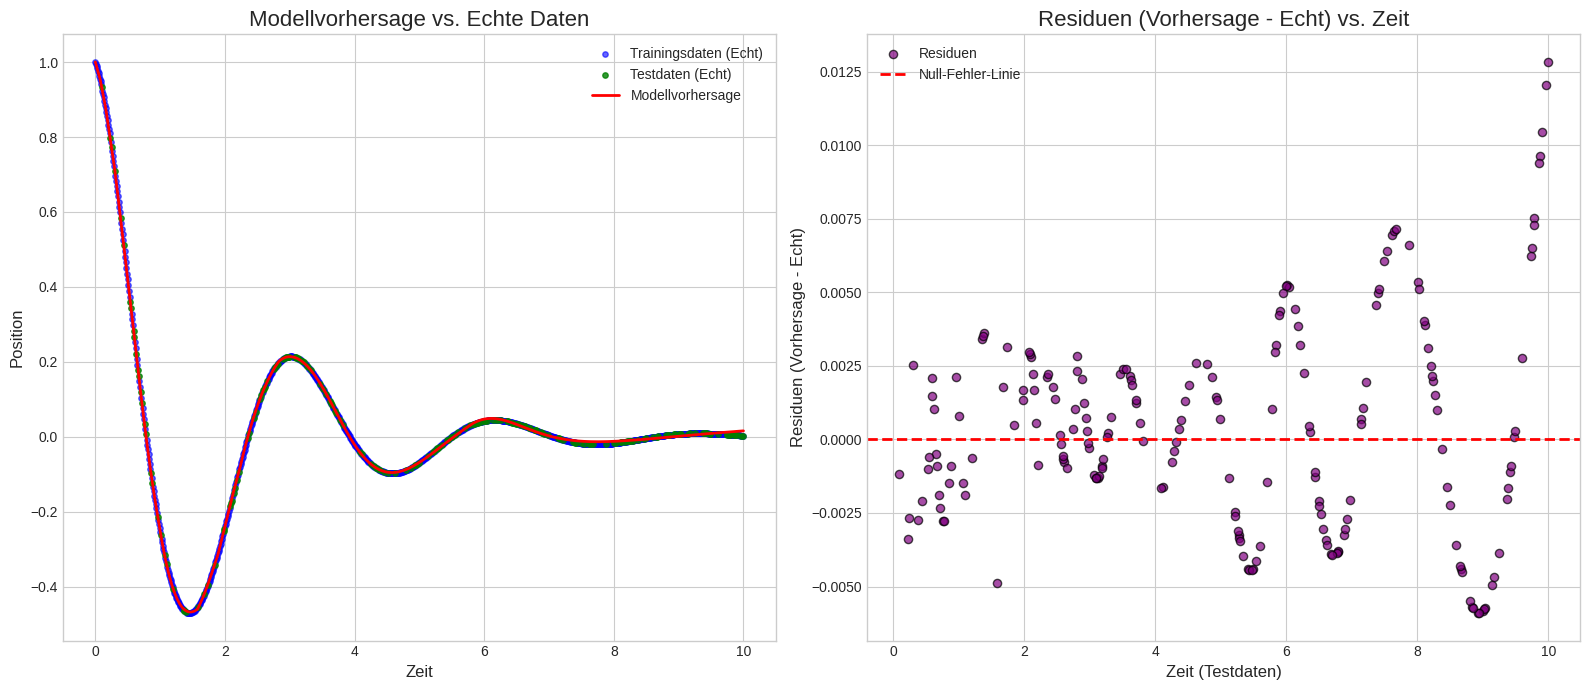

In [23]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- 1. Daten vorbereiten ---
def generate_damped_oscillator_data(num_samples=1000, noise_amplitude=0.00):
    """Generiert synthetische Daten für einen gedämpften Oszillator."""
    time_steps = np.linspace(0, 10, num_samples)
    positions = 1.0 * np.exp(-0.5 * time_steps) * np.cos(2.0 * time_steps) + \
                noise_amplitude * np.random.randn(num_samples)
    return time_steps, positions

# Daten generieren und aufteilen
time_data, position_data = generate_damped_oscillator_data()
X = time_data.reshape(-1, 1)
y = position_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Modell erstellen und kompilieren ---
def build_simple_model(input_shape=(1,)):
    """Erstellt das spezifizierte neuronale Netz."""
    model = tf.keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=input_shape),
        layers.Dense(16, activation='tanh'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model

model = build_simple_model()
model.summary()

# --- 3. Modell trainieren ---
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping_callback],
    verbose=1
)

# --- 4. Modell evaluieren ---
print("\nModell-Evaluierung auf dem Testset:")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"  - Mittlerer quadratischer Fehler (MSE): {loss:.4f}")
print(f"  - Mittlere absolute Abweichung (MAE): {mae:.4f}")

# --- 5. Trainingsverlauf visualisieren (Log-Log Plots) ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 6))

# Plot für den Trainings- und Validierungsverlust (MSE) im Log-Log-Maßstab
ax1 = plt.subplot(1, 2, 1)
# Erstelle Epochen-Array für die x-Achse (beginnend bei 1)
epochs_range = range(1, len(history.history['loss']) + 1)
ax1.loglog(epochs_range, history.history['loss'], label='Trainings-Verlust (MSE)')
ax1.loglog(epochs_range, history.history['val_loss'], label='Validierungs-Verlust (MSE)')
ax1.set_title('Modell-Verlust während des Trainings (Log-Log)')
ax1.set_xlabel('Epoche (Log-Skala)')
ax1.set_ylabel('Verlust (MSE) (Log-Skala)')
ax1.legend()
ax1.grid(True, which="both", ls="-") # Gitter für Log-Skala anpassen

# Plot für die Trainings- und Validierungs-MAE im Log-Log-Maßstab
ax2 = plt.subplot(1, 2, 2)
ax2.loglog(epochs_range, history.history['mean_absolute_error'], label='Trainings-MAE')
ax2.loglog(epochs_range, history.history['val_mean_absolute_error'], label='Validierungs-MAE')
ax2.set_title('Modell-MAE während des Trainings (Log-Log)')
ax2.set_xlabel('Epoche (Log-Skala)')
ax2.set_ylabel('MAE (Log-Skala)')
ax2.legend()
ax2.grid(True, which="both", ls="-") # Gitter für Log-Skala anpassen

plt.tight_layout()
plt.show()


# --- 6. Vorhersagen visualisieren (mit geändertem zweiten Plot) ---
# Vorhersagen für beide Datensätze machen
y_pred_full = model.predict(X)
y_pred_test = model.predict(X_test) # Wird (Anzahl_Samples, 1) zurückgeben

fig, (ax1_viz, ax2_viz) = plt.subplots(1, 2, figsize=(16, 7)) # Umbenannt, um Konflikte mit obigen ax1, ax2 zu vermeiden

# Plot 1: Vorhersage über die gesamten Daten (BLEIBT GLEICH)
ax1_viz.scatter(X_train, y_train, label='Trainingsdaten (Echt)', alpha=0.6, s=15, color='blue')
ax1_viz.scatter(X_test, y_test, label='Testdaten (Echt)', alpha=0.8, s=15, color='green')
ax1_viz.plot(time_data, y_pred_full, color='red', linewidth=2, label='Modellvorhersage')
ax1_viz.set_title('Modellvorhersage vs. Echte Daten', fontsize=16)
ax1_viz.set_xlabel('Zeit', fontsize=12)
ax1_viz.set_ylabel('Position', fontsize=12)
ax1_viz.legend(fontsize=10)
ax1_viz.grid(True)

# Plot 2: Residuen (y_vorhergesagt - y_echt) vs. Zeit (NEU)
# Stelle sicher, dass y_test und y_pred_test die gleiche Form für die Subtraktion haben
# y_test ist (n_samples,), y_pred_test ist (n_samples, 1), also y_pred_test.flatten() verwenden
residuals = y_pred_test.flatten() - y_test
time_test_flat = X_test.flatten() # X_test ist (n_samples, 1)

# Sortiere Residuen nach Zeit für eine saubere Linienzeichnung, falls gewünscht,
# oder verwende einen Scatterplot, der keine Sortierung benötigt.
# Für einen Scatterplot ist keine Sortierung notwendig.
ax2_viz.scatter(time_test_flat, residuals, alpha=0.7, color='purple', edgecolors='k', s=35, label='Residuen')
ax2_viz.axhline(0, color='red', linestyle='--', lw=2, label='Null-Fehler-Linie') # Linie bei y=0
ax2_viz.set_title('Residuen (Vorhersage - Echt) vs. Zeit', fontsize=16)
ax2_viz.set_xlabel('Zeit (Testdaten)', fontsize=12)
ax2_viz.set_ylabel('Residuen (Vorhersage - Echt)', fontsize=12)
ax2_viz.legend(fontsize=10)
ax2_viz.grid(True)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0164 - mean_absolute_error: 0.9093 - val_loss: 0.0402 - val_mean_absolute_error: 0.1548
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0617 - mean_absolute_error: 0.1626 - val_loss: 0.0333 - val_mean_absolute_error: 0.1095
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0544 - mean_absolute_error: 0.1410 - val_loss: 0.0303 - val_mean_absolute_error: 0.1166
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0470 - mean_absolute_error: 0.1341 - val_loss: 0.0271 - val_mean_absolute_error: 0.1090
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0352 - mean_absolute_error: 0.1170 - val_loss: 0.0245 - val_mean_absolute_error: 0.0997
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0354 - mean_absolute_error: 0.1179 - val_loss: 0.0226 - val_mean_absolute_error: 0.0967
Epoch 7/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0332 - mean_absolute_error: 0.1160 - 

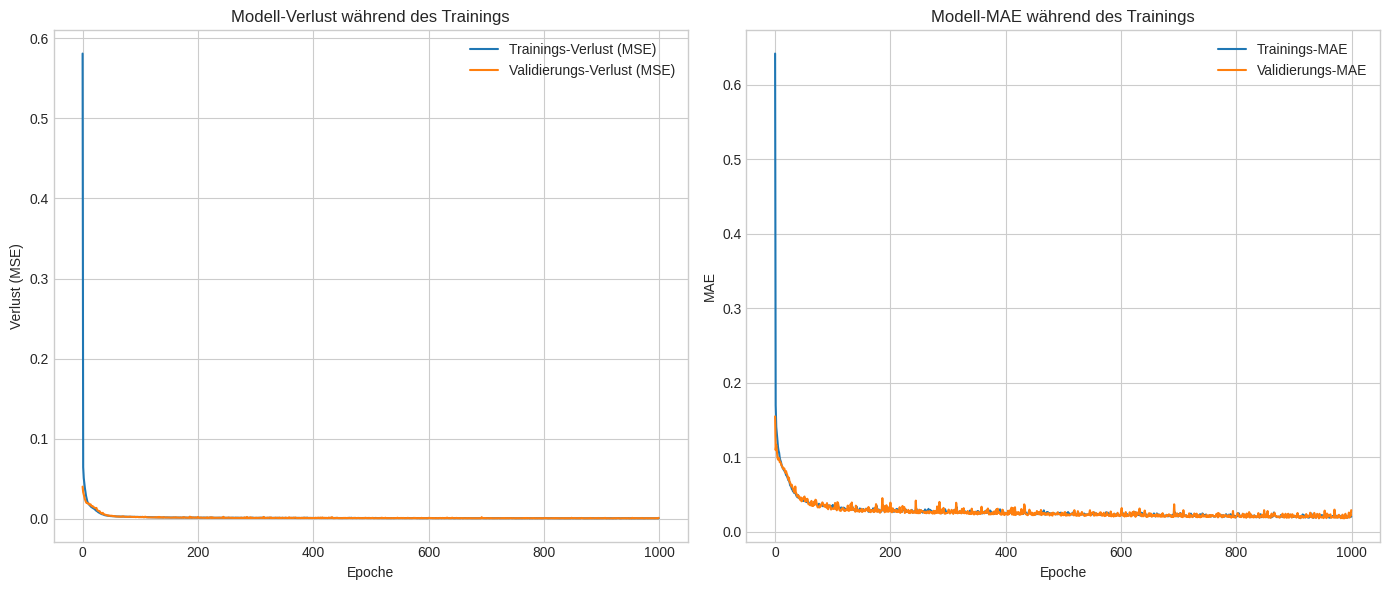

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


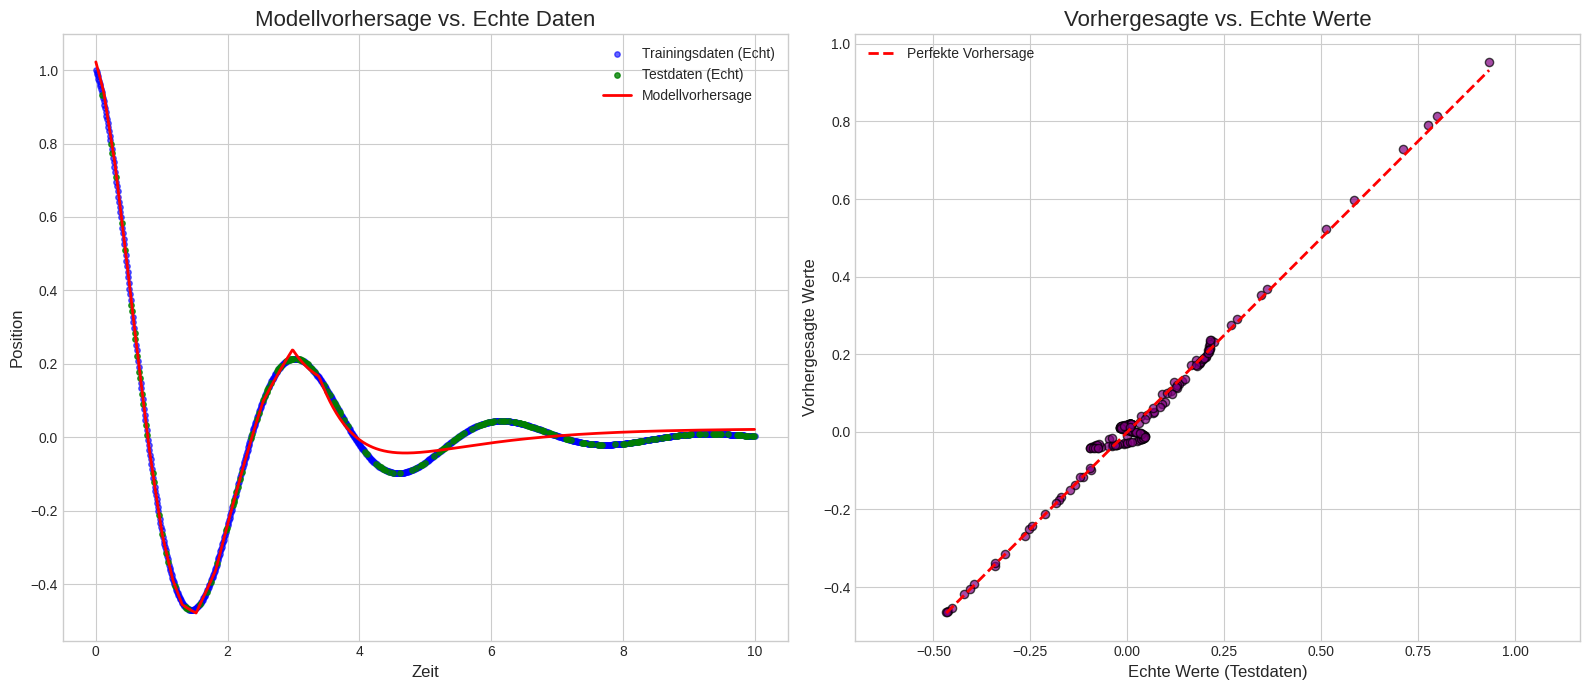

In [21]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- 1. Daten vorbereiten ---
def generate_damped_oscillator_data(num_samples=1000, noise_amplitude=0.00):
    """Generiert synthetische Daten für einen gedämpften Oszillator."""
    time_steps = np.linspace(0, 10, num_samples)
    positions = 1.0 * np.exp(-0.5 * time_steps) * np.cos(2.0 * time_steps) + \
                noise_amplitude * np.random.randn(num_samples)
    return time_steps, positions

# Daten generieren und aufteilen
time_data, position_data = generate_damped_oscillator_data()
X = time_data.reshape(-1, 1)
y = position_data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Modell erstellen und kompilieren ---
def build_simple_model(input_shape=(1,)):
    """Erstellt das spezifizierte neuronale Netz."""
    model = tf.keras.Sequential([
        layers.Dense(16, activation='tanh', input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        # Ausgabeschicht: 1 Neuron für die Vorhersage der Position
        layers.Dense(1)
    ])

    # Modell kompilieren mit dem Adam-Optimierer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error', # Übliche Verlustfunktion für Regression
                  metrics=['mean_absolute_error']) # Metrik zur Überwachung
    return model

# Modell instanziieren und Zusammenfassung anzeigen
model = build_simple_model()
model.summary()

# --- 3. Modell trainieren ---
# Callback für Early Stopping: Stoppt das Training, wenn sich der Validierungsverlust nicht mehr verbessert.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=50, # Anzahl der Epochen ohne Verbesserung, bevor gestoppt wird
    restore_best_weights=True # Stellt die besten Gewichte am Ende wieder her
)

# Training starten
history = model.fit(
    X_train, y_train,
    epochs=1000, # Maximale Anzahl an Epochen
    validation_data=(X_test, y_test), # Wir verwenden das Test-Set zur Validierung
    batch_size=32,
    callbacks=[early_stopping_callback], # Callback übergeben
    verbose=1 # Weniger detaillierte Ausgabe während des Trainings
)

# --- 4. Modell evaluieren ---
print("\nModell-Evaluierung auf dem Testset:")
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"  - Mittlerer quadratischer Fehler (MSE): {loss:.4f}")
print(f"  - Mittlere absolute Abweichung (MAE): {mae:.4f}")

# --- 5. Trainingsverlauf visualisieren ---
# Dieser Abschnitt plottet den Verlauf von Verlust und MAE während des Trainings.
# Die Bezeichnungen 'loss', 'val_loss', 'mean_absolute_error' und 'val_mean_absolute_error'
# stammen direkt aus dem history-Objekt, das von model.fit() zurückgegeben wird
# und entsprechen den in model.compile() definierten Verlust- und Metrikfunktionen.

plt.style.use('seaborn-v0_8-whitegrid') # Stil beibehalten für Konsistenz
plt.figure(figsize=(14, 6)) # Eine neue Figur für diese Plots

# Plot für den Trainings- und Validierungsverlust (MSE)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Trainings-Verlust (MSE)')
plt.plot(history.history['val_loss'], label='Validierungs-Verlust (MSE)')
plt.title('Modell-Verlust während des Trainings')
plt.xlabel('Epoche')
plt.ylabel('Verlust (MSE)')
plt.legend()
plt.grid(True)

# Plot für die Trainings- und Validierungs-MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Trainings-MAE') # Korrekter Key
plt.plot(history.history['val_mean_absolute_error'], label='Validierungs-MAE') # Korrekter Key
plt.title('Modell-MAE während des Trainings')
plt.xlabel('Epoche')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout() # Passt die Plots an, um Überlappungen zu vermeiden
plt.show()


# --- 6. Vorhersagen visualisieren ---
# Vorhersagen für beide Datensätze machen
y_pred_full = model.predict(X)
y_pred_test = model.predict(X_test)

# Visualisierung der Vorhersagen (dein ursprünglicher Code für diese Plots)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Vorhersage über die gesamten Daten
ax1.scatter(X_train, y_train, label='Trainingsdaten (Echt)', alpha=0.6, s=15, color='blue')
ax1.scatter(X_test, y_test, label='Testdaten (Echt)', alpha=0.8, s=15, color='green')
ax1.plot(time_data, y_pred_full, color='red', linewidth=2, label='Modellvorhersage')
ax1.set_title('Modellvorhersage vs. Echte Daten', fontsize=16)
ax1.set_xlabel('Zeit', fontsize=12)
ax1.set_ylabel('Position', fontsize=12)
ax1.legend(fontsize=10)

# Plot 2: Vorhergesagte vs. Echte Werte (Predicted vs. Actual)
ax2.scatter(y_test, y_pred_test, alpha=0.7, color='purple', edgecolors='k', s=35)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfekte Vorhersage')
ax2.set_title('Vorhergesagte vs. Echte Werte', fontsize=16)
ax2.set_xlabel('Echte Werte (Testdaten)', fontsize=12)
ax2.set_ylabel('Vorhergesagte Werte', fontsize=12)
ax2.legend(fontsize=10)
ax2.axis('equal') # Sorgt für ein quadratisches Plotverhältnis

plt.tight_layout()
plt.show()

Test 2 with parameter init